In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

2023-11-29 10:42:22.840196: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 10:42:22.841708: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 10:42:22.866338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 10:42:22.866370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 10:42:22.867035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
train_df = pd.read_csv("../data/raw/sign_mnist_train.csv")
test_df = pd.read_csv("../data/raw/test.csv")
old_test_df = pd.read_csv("../data/raw/old_sign_mnist_test.csv")

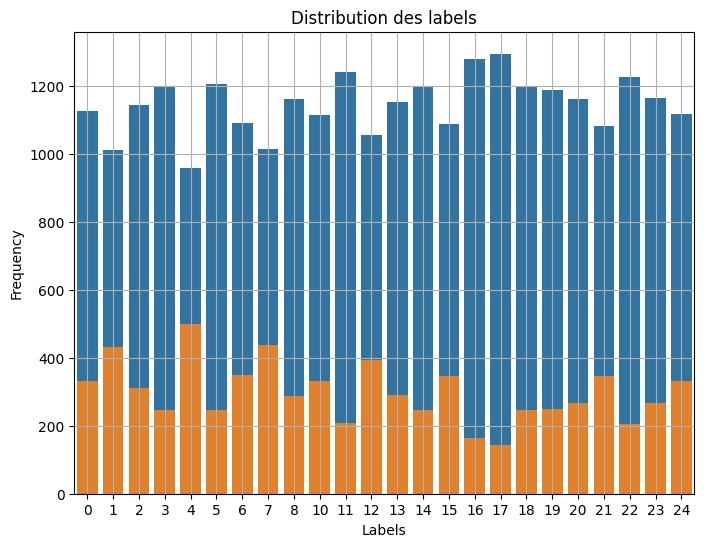

In [3]:
# Creating histogram
plt.figure(figsize=(8, 6))
sns.countplot(x=train_df['label'])  
sns.countplot(x=old_test_df['label'])  
# Adding labels and title
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution des labels')
plt.grid(True)
plt.show()

In [4]:
y_train = train_df['label']
y_val = old_test_df['label']

from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()

y_train = label_binarizer.fit_transform(y_train)
y_val = label_binarizer.fit_transform(y_val)

X_train = train_df.drop(columns=['label']).values/255
X_val = old_test_df.drop(columns=['label']).values/255

X_train = X_train.reshape(-1,28,28,1)
X_val = X_val.reshape(-1,28,28,1)

In [5]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [6]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)

In [7]:
# model 1
m1_model = Sequential()
m1_model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
m1_model.add(BatchNormalization())
m1_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
m1_model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
m1_model.add(Dropout(0.2))
m1_model.add(BatchNormalization())
m1_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
m1_model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
m1_model.add(BatchNormalization())
m1_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
m1_model.add(Flatten())
m1_model.add(Dense(units = 512 , activation = 'relu'))
m1_model.add(Dropout(0.3))
m1_model.add(Dense(units = 24 , activation = 'softmax'))
m1_model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 50)        2

In [8]:
epochs = 15
history = model.fit(datagen.flow(X_train,y_train, batch_size = 128) ,epochs = epochs , validation_data = (X_val, y_val) , callbacks = [learning_rate_reduction])
weights_path = os.path.join('..','data','weights',f'model_weights_{epochs}.h5')
model.save_weights(weights_path)

Epoch 1/15
215/215 [==============================] - 18s 80ms/step - loss: 1.0972 - accuracy: 0.6574 - val_loss: 3.6582 - val_accuracy: 0.0998 - lr: 0.0010
Epoch 2/15
215/215 [==============================] - 16s 75ms/step - loss: 0.2179 - accuracy: 0.9272 - val_loss: 1.1304 - val_accuracy: 0.6514 - lr: 0.0010
Epoch 3/15
215/215 [==============================] - 17s 79ms/step - loss: 0.1032 - accuracy: 0.9669 - val_loss: 0.1815 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 4/15
215/215 [==============================] - 17s 80ms/step - loss: 0.0696 - accuracy: 0.9771 - val_loss: 0.5844 - val_accuracy: 0.8199 - lr: 0.0010
Epoch 5/15
215/215 [==============================] - 18s 82ms/step - loss: 0.0464 - accuracy: 0.9855 - val_loss: 0.1167 - val_accuracy: 0.9618 - lr: 0.0010
Epoch 6/15
215/215 [==============================] - 17s 81ms/step - loss: 0.0352 - accuracy: 0.9888 - val_loss: 0.0301 - val_accuracy: 0.9915 - lr: 0.0010
Epoch 7/15
215/215 [==============================] - 18s 

In [9]:
print("Accuracy of the model is - " , model.evaluate(X_val,y_val)[1]*100 , "%")

225/225 [==============================] - 2s 7ms/step - loss: 7.5731e-04 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


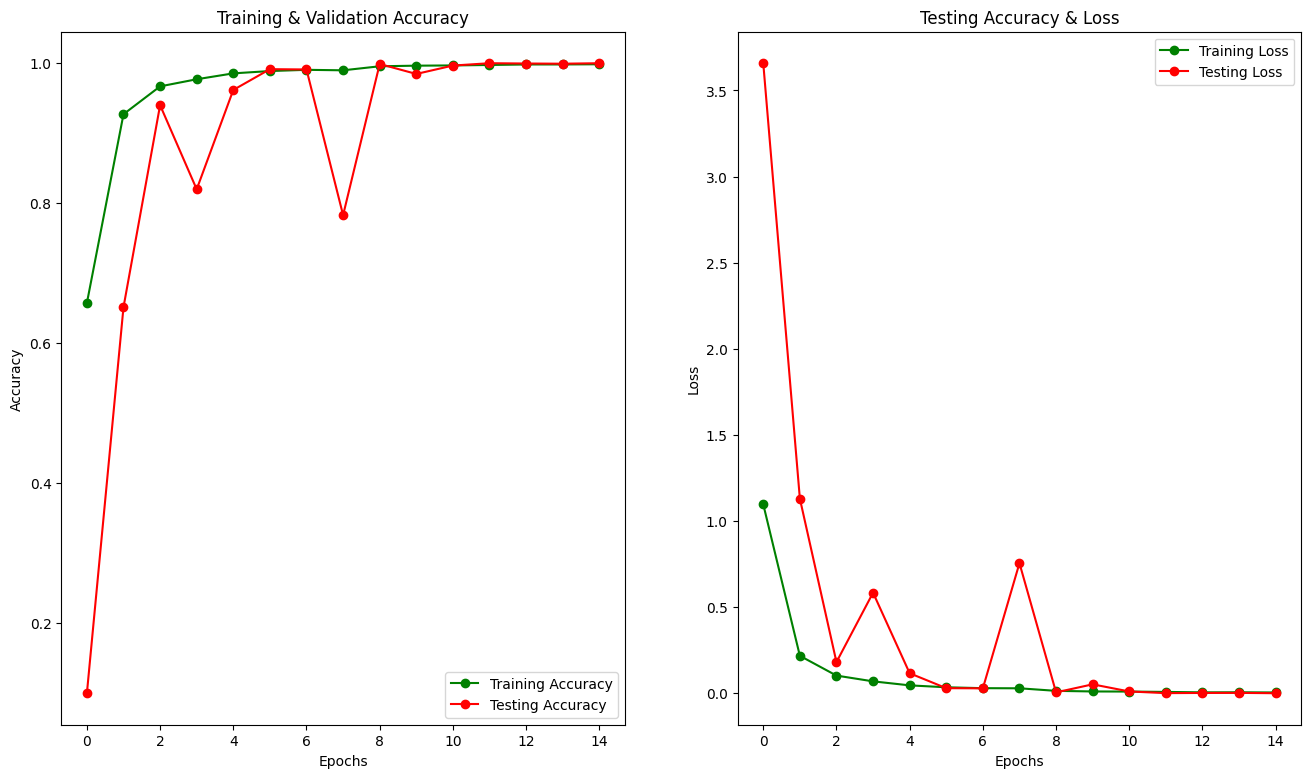

In [14]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

94/94 [==============================] - 1s 10ms/step
[ 6  2  1 13 10 21 19 14  4 24]
94/94 [==============================] - 1s 9ms/step
[19 23  5 14 17 23 12  0 13  0]


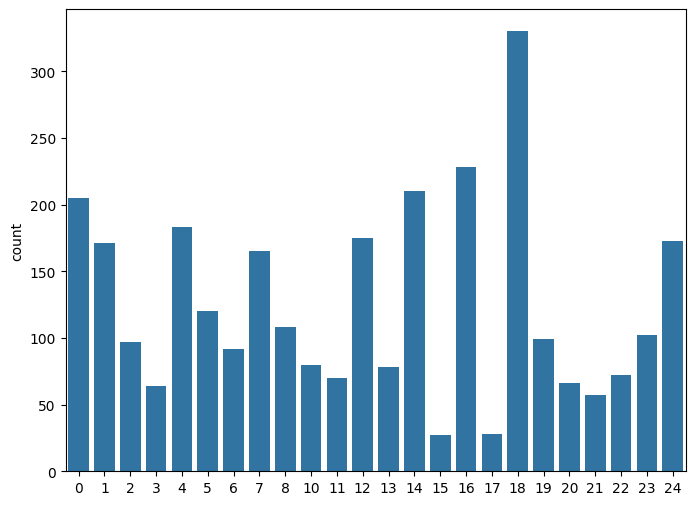

In [15]:
import sys
sys.path.append('..')
from scripts.Data import *
# Splitting columns A1 to A784 into a separate DataFrame
df_A = test_df.filter(like='pixel_a')
test_A = df_A.values.reshape(-1,28,28,1)

y_pred_A = np.argmax(model.predict(test_A), axis=1)
y_pred_A[y_pred_A >= 9] +=  1


plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred_A)  
print(y_pred_A[:10])


# Splitting columns B1 to B784 into a separate DataFrame
df_B = test_df.filter(like='pixel_b')
test_B = df_B.values.reshape(-1,28,28,1)

y_pred_B = np.argmax(model.predict(test_B),axis=1)
y_pred_B[y_pred_B >= 9] +=  1
print(y_pred_B[:10])
transformed_labels = [transform_labels(label_A, label_B) for label_A, label_B in zip(y_pred_A, y_pred_B)]

IDS = np.arange(len(transformed_labels))
res = pd.DataFrame(data={"id":IDS, 'label':transformed_labels})

prediction_path = os.path.join('..','data','prediction','cnn.csv')
#print(res.head(10))
#print(np.unique(res['label'], return_counts=True))
res.to_csv(prediction_path, index=False)

In [ ]:
ord('A')

In [ ]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(test_A[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()


f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(test_B[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()   

In [ ]:

old_test = old_test_df.drop(columns=['label']).values.reshape(-1,28,28,1)
print(old_test_df['label'].head(10))
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(old_test[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()   